# CE-40959: Advanced Machine Learning
## HW2 - Optimization-based Meta Learning (100 points)

#### Name:  Sepehr Ghobadi
#### Student No.:  400211008

In this notebook, you are going to implement a optimization-based meta learner using the `Omniglot` dataset.

Please write your code in specified sections and do not change anything else. If you have a question regarding this homework, please ask it on the Quera.

Also, it is recommended to use Google Colab to do this homework. You can connect to your drive using the code below:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Required libraries

In [1]:
import numpy as np
import os, itertools, copy
import matplotlib.pyplot as plt

import torch
import torchvision
import random
import torch.nn as nn
import math

import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data

from tqdm import tqdm

## Introduction

In Meta-Learning literature and in the meta-training phase, you are given some batches which consist of `support` and `query` sets. you train your model in a way that by using a support set you could predict query set labels correctly.

The pioneer of this branch is Model-Agnostic Meta-Learning(MAML). 

First, we should build the dataset in this way that each batch returns N*(k+k') images. `k` is the number of support images per class and `k'` is the number of query images per class in a batch.

The Omniglot data set is designed for developing more human-like learning algorithms. It contains 1623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people.

Train and test dataset contains 964 and 659 classes, respectively. Torchvision-based Omniglot dataset is ordered and every 20 images in a row belong to one class.

In [2]:
# Meta learning parameters.

N = 5
support_size = 1
query_size = 15

## Prepare dataset (5 points)

In [3]:
transform = transforms.Compose([
     transforms.Resize(28),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)
])

train_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = True, transform = transform)
test_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = False, transform = transform)

train_labels = np.repeat(np.arange(964), 20)
test_labels = np.repeat(np.arange(659), 20)

  0%|          | 0/9464212 [00:00<?, ?it/s]


KeyboardInterrupt



To build a dataloader, we should have a class that yields indexes of selected data in the dataset for every iteration and pass it to the `batch_sampler` attribute of dataloader.

Complete below code based on this pseudocode:


1.   select `N` classes randomly from all classes
2.   select `support_size + query_size` images from each classes independently and randomly
3.   shuffle dataset indexes, but don't forget to put query indexes at the last of the list

In [5]:
class BatchSampler(object):
    '''
    BatchSampler: yield a batch of indexes at each iteration.
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, labels, classes_per_it, num_support_samples, num_query_samples, iterations, batch_size):
        '''
        Initialize the BatchSampler object
        Args:
        - labels: array of labels of dataset.
        - classes_per_it: number of random classes for each iteration
        - num_samples: number of samples for each iteration for each class
        - iterations: number of iterations (episodes) per epoch
        - batch_size: number of batches per iteration
        '''
        super(BatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.support_sample_per_class = num_support_samples
        self.query_sample_per_class = num_query_samples
        self.iterations = iterations
        self.batch_size = batch_size

        self.classes = np.unique(self.labels)
        self.indices = np.arange(len(self.labels))

    def __iter__(self):
        '''
        yield a batch of indexes
        '''

        for it in range(self.iterations):
            total_batch_indexes = np.array([])

            #################################################################################
            #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
            #################################################################################
            # feel free to add/edit initialization part of sampler.
            #################################################################################

            for _ in range(self.batch_size):
                supports = np.array([], dtype=np.int64)
                queries = np.array([], dtype=np.int64)
                sample_classes = np.random.choice(self.classes , size=self.classes_per_it, replace=False)
                for c in sample_classes:
                    class_samples = np.random.choice(self.indices[self.labels==c], size=self.support_sample_per_class+self.query_sample_per_class, replace=False)
                    supports = np.append(supports, class_samples[0:self.support_sample_per_class])
                    queries = np.append(queries, class_samples[self.support_sample_per_class:])
                np.random.shuffle(supports)
                np.random.shuffle(queries)
                total_batch_indexes = np.append(total_batch_indexes, np.append(supports, queries))
            #total_batch_indexes = np.reshape(total_batch_indexes, (self.batch_size,-1))    
            
            #################################################################################
            #                                   THE END                                     #
            #################################################################################

            yield total_batch_indexes.astype(int)

    def __len__(self):
        return self.iterations

In [6]:
iterations = 1000
batch_size = 32

train_sampler = BatchSampler(labels=train_labels, classes_per_it=N,
                              num_support_samples=support_size, num_query_samples=query_size, iterations=iterations,
                              batch_size=batch_size)

test_sampler = BatchSampler(labels=test_labels, classes_per_it=N,
                              num_support_samples=support_size, num_query_samples=query_size, iterations=iterations,
                              batch_size=batch_size)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler)

## Model (45 points)

Let's Build our model. the whole model is `ProtoNet` feature extractor which is used in [Prototypical Network paper](https://arxiv.org/abs/1703.05175) but due to the lack of enough computational resources for first part of question, we give you some part of the network as pretraining and only you will do meta-training on the last layer of the network.

In [7]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class Feature_extractor(nn.Module):
    '''
    source: https://github.com/jakesnell/prototypical-networks/blob/f0c48808e496989d01db59f86d4449d7aee9ab0c/protonets/models/few_shot.py#L62-L84
    '''
    def __init__(self, x_dim=1, hid_dim=64):
        super(Feature_extractor, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim)
        )

    def forward(self, x):
        return self.encoder(x)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = Feature_extractor()
feature_extractor = feature_extractor.to(device)
feature_extractor.load_state_dict(torch.load('./pretrained_model.pt', map_location=device))

<All keys matched successfully>

To be specific, you are going to get the features of each image via the feature extraction network and give the output of that as input to your meta-learner. at the end of initialization, you should have initialized your network parameters and have saved them on the given ParameterList for future forward passes.

The `Learner` class is a module that initializes your meta-parameters based on your given config as input. the format of config is arbitrary and you should prepare required parameters for initializing your submodules. do a quick look at the modules of meta-network to implement your Learner class.

At forwarding pass, you give your input and two optional attributes.

1.   **vars**: the default value of this attribute is None and it means that meta-learner will use its own parameters for forwarding pass, but you can give your desired parameters for computing output
2.   **bn_training**: if True, batch normalization layers show the same behavior as training time.


In the `zero_grad` method, you are going to set the gradient of given parameters as attribute or class parameters (self.vars) to zero.





In [9]:
class Learner(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Learner, self).__init__()

        self.cfg = kwargs['config']
        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()
        
        self.is_freezed = []

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        # initialize your meta-network parameters based on given config.
        #################################################################################


        vars_idx = 0
        vars_bn_idx = 0
        for idx, params in enumerate(self.cfg):

            if "dim" in params.keys():
                if params['pretrained_params'] is None:
                    weights = nn.Parameter(torch.zeros(*params["dim"]))
                    bias = nn.Parameter(torch.zeros(params["dim"][0]))
                    nn.init.normal_(weights)
                    nn.init.normal_(bias)
                else:
                    weights = nn.Parameter(params['pretrained_params']['weights'])
                    bias = nn.Parameter(params['pretrained_params']['bias'])
                    
                self.vars.append(weights)
                self.vars.append(bias)
                self.is_freezed.append(params['requires_grad']) # for weight
                self.is_freezed.append(params['requires_grad']) # for bias
                
                vars_idx+=1

            if params['layer'] == "bn":
                if params['pretrained_params'] is None:
                    mm = nn.Parameter(torch.zeros(params["dim"][0]), requires_grad=False)
                    mv = nn.Parameter(torch.ones(params["dim"][0]), requires_grad=False)
                else:
                    mm = nn.Parameter(params['pretrained_params']['running_mean'], requires_grad=False)
                    mv = nn.Parameter(params['pretrained_params']['running_var'], requires_grad=False)
                
                self.vars_bn.append(mm)
                self.vars_bn.append(mv)
                
                vars_bn_idx+=1


        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def forward(self, x, vars=None, bn_training=True):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        # compute output of input with given parameters or class parameters
        #################################################################################

        vars = self.vars if vars is None else vars
        vars_bn = self.vars_bn

        
        modules = {
          'conv2d': F.conv2d,
          'bn': F.batch_norm,
          'relu': F.relu,
          'max_pool': F.max_pool2d,
          'flatten': torch.flatten,
          'linear': F.linear,
        }
                
        vars_idx = 0
        vars_bn_idx = 0
        for idx, params in enumerate(self.cfg):
            kwargs = {
                'conv2d': {'input':x, 'weight':vars[2*vars_idx], 'bias':vars[2*vars_idx+1], 'stride':params.get('stride'), 'padding':params.get('padding')},
                'bn': {'input':x, 'running_mean':vars_bn[2*vars_bn_idx], 'running_var':vars_bn[2*vars_bn_idx+1], 'weight':vars[2*vars_idx], 'bias':vars[2*vars_idx+1], 'training':bn_training},
                'relu': {'input':x},
                'max_pool': {'input':x, 'kernel_size': params.get('kernel_size'), 'stride':params.get('stride')},
                'flatten': {'input':x, 'start_dim':1},
                'linear': {'input':x, 'weight':vars[2*vars_idx], 'bias':vars[2*vars_idx+1]}
            }
            
            x = modules[params['layer']](**kwargs[params['layer']])
            
            if "dim" in params.keys() and 2*(vars_idx+1)!=len(vars):
                vars_idx+=1
            if params['layer'] == "bn" and 2*(vars_bn_idx+1)!=len(vars_bn): # second is for creating kwargs dict problems
                vars_bn_idx+=1
            
        return x


        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def zero_grad(self, vars=None):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
        #################################################################################
        # set gradient of given parameters as attribute or class parameters to zero
        #################################################################################
        with torch.no_grad():
            for param in (self.vars if vars is None else vars):
                if param.grad is not None:
                    param.grad.zero_()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def parameters(self):
        return self.vars
    
    def freezed_layers(self):
        return self.is_freezed

Now at the `Meta` module, you implement your meta-learner module. you give your all support and query data to your module and the model will update your `Learner` parameters based on MAML-loss.
to clarify, you pass your support data to `Learner` and then calculate the loss on them and update your parameters and then continue to update your parameters based on the given number of inner-loop updates and finally calculate the loss on query data and update `Learner` parameters

In [10]:
class Meta(nn.Module):
    def __init__(self, *args, **kwargs):

        super(Meta, self).__init__()

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                   #
        #################################################################################
        # initialize your meta-learner
        #################################################################################

        self.inner_loop_lr = kwargs['inner_loop_lr']
        self.inner_loop_steps = kwargs['inner_loop_steps']
        self.criterion = kwargs['criterion']
        self.num_tasks = kwargs['num_tasks']
        
        self.learner = Learner(config=kwargs['config'])
        self.inner_loop_optim = optim.Adam(self.learner.parameters(), lr=self.inner_loop_lr)

        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def forward(self, x_s, y_s, x_q, y_q):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (15 points)                   #
        #################################################################################
        # meta-train your parameters.
        #################################################################################

        losses, accs, finetuned_weights= [], [], []
        
        for t in range(self.num_tasks):
            inner_loop_weights = self.learner.parameters()
            for inner_step in range(self.inner_loop_steps):
                logits = self.learner(x_s[t], vars=inner_loop_weights, bn_training=True)
                loss = self.criterion(logits, y_s[t])
                inner_grad = torch.autograd.grad(loss, inner_loop_weights)
                inner_loop_weights = [weight - self.inner_loop_lr*grad*int(is_freezed) for (weight, grad, is_freezed) in zip(inner_loop_weights, inner_grad, self.learner.freezed_layers())]
            logits = self.learner(x_q[t], vars=inner_loop_weights, bn_training=True)
            losses.append(self.criterion(logits, y_q[t]))
            preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
            accs.append( torch.sum(y_q[t]==preds)/y_q[t].size(0) )
            finetuned_weights.append(inner_loop_weights)
        
        return losses, accs, finetuned_weights



        #################################################################################
        #                                   THE END                                     #
        #################################################################################






In [12]:
def train(model_path, cfg, epochs, train_dataloader, test_dataloader, meta_inner_lr, inner_loop_steps, meta_outer_lr, criterion):
    meta_learner = Meta(num_tasks=batch_size, inner_loop_lr=meta_inner_lr, inner_loop_steps=inner_loop_steps, criterion=criterion, config=cfg).to(device)
    if model_path is not None:
        meta_learner.load_state_dict(torch.load(model_path, map_location=device))
    optimizer = optim.Adam(meta_learner.learner.parameters(), lr=meta_outer_lr)
    test_acc = 0
    for _ in range(epochs):
        train_losses, train_accs = [], []
        for idx, (x, y) in enumerate(tqdm(train_dataloader)):
            x = x.reshape(batch_size,N*(support_size+query_size),1,28,28).to(device)
            y = y.reshape(batch_size,N*(support_size+query_size)).to(device)
            for task in range(batch_size):
                y[task] = y[task].unique(return_inverse=True)[1]
            x_s, y_s = x[:,0:support_size*N,:], y[:,0:support_size*N]
            x_q, y_q = x[:,support_size*N:,:], y[:,support_size*N:]
            batch_losses, batch_accs, batch_finetuned_weights = meta_learner(x_s, y_s, x_q, y_q)

            optimizer.zero_grad()
            loss = torch.mean(torch.stack(batch_losses))
            loss.backward()
            optimizer.step()

            train_losses.append( loss.item() )

            acc = torch.mean(torch.stack(batch_accs))
            train_accs.append( acc.item() )
            # if idx%100 == 0:
            #     torch.save(meta_learner.state_dict(), '/content/drive/MyDrive/MAML{}.pt'.format(inner_loop_steps))
            #     torch.save(optimizer.state_dict(), '/content/drive/MyDrive/MAMLOPT.pt')
            torch.save(meta_learner.state_dict(), '/content/drive/MyDrive/MAMLFULL.pt')
        
        print("train loss: {}.     train acc: {}".format(np.mean(train_losses), np.mean(train_accs)))
        

    test_losses, test_accs = [], []
    #with torch.no_grad():
    for idx, (x, y) in enumerate(tqdm(test_dataloader)):
      x = x.reshape(batch_size,N*(support_size+query_size),1,28,28).to(device)
      y = y.reshape(batch_size,N*(support_size+query_size)).to(device)
      for task in range(batch_size):
          y[task] = y[task].unique(return_inverse=True)[1]

      x_s, y_s = x[:,0:support_size*N,:], y[:,0:support_size*N]
      x_q, y_q = x[:,support_size*N:,:], y[:,support_size*N:]

      batch_losses, batch_accs, batch_finetuned_weights = meta_learner(x_s, y_s, x_q, y_q)

      loss = torch.mean(torch.stack(batch_losses))
      test_losses.append(loss.item())
      acc = torch.mean(torch.stack(batch_accs))
      test_accs.append( acc.item() )

    print("\ntest loss: {}.     test acc: {}".format(np.mean(test_losses), np.mean(test_accs)))
    
    return np.mean(test_accs)
    



In [13]:
def get_layer(in_channels, requires_grad, pretrained, feature_extractor=None, layer_idx=None):
    if pretrained:
        pretrained_params = feature_extractor.state_dict()
        pretrained_conv2d = {
            'weights' : pretrained_params['encoder.'+str(layer_idx)+'.0.weight'],
            'bias' : pretrained_params['encoder.'+str(layer_idx)+'.0.bias']
        }
        pretrained_bn = {
            'weights' : pretrained_params['encoder.'+str(layer_idx)+'.1.weight'],
            'bias' : pretrained_params['encoder.'+str(layer_idx)+'.1.bias'],
            #'num_batches_tracked' : pretrained_params['encoder.'+str(layer_idx)+'.1.num_batches_tracked']
            'running_mean' : pretrained_params['encoder.'+str(layer_idx)+'.1.running_mean'],
            'running_var' : pretrained_params['encoder.'+str(layer_idx)+'.1.running_var']
        }
    else:
        pretrained_conv2d, pretrained_bn = None, None
        
    return [
        {'layer':'conv2d', 'dim':[64, in_channels, 3, 3], 'stride':1, 'padding':1, 'requires_grad':requires_grad, 'pretrained_params':pretrained_conv2d},
        {'layer':'bn', 'dim':[64], 'requires_grad':requires_grad, 'pretrained_params':pretrained_bn},
        {'layer':'relu'},
        {'layer':'max_pool', 'kernel_size':2, 'stride':2}
    ]

## With Feature Extractor

Your Meta-network which you are going to initialize your Learner based on it for first part of question is as follows:


1.   **Conv2d layer**: in_channels=64, out_channels:64, kernel_size=3, stride=1, padding=1
2.   **BatchNorm2D layer**: out_channels=64
3.   **ReLU activation**
4.   **Max Pooling layer**: kernel_size = 2, stride = 2
5.   **Flatten layer**
6.   **Linear layer**: in_features=64, out_features=N (number of classes in meta-learning)




Meta-train **three** different networks with three different inner loop updates=[1, 2, 3]. after some reasonable epochs, plot accuracy of meta-test phase based on inner loop update parameter on each network.

### Train (25 points)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (25 points)                   #
#################################################################################
# Define your config and initialize model and parameters
# prepare your data as input to your model.
# train meta-network
# get acurracy of model in meta-test phase
#################################################################################
epochs = 3
criterion = F.cross_entropy
#inner_loop_steps=3
meta_inner_lr = 0.4
meta_outer_lr = 0.001



cfg = [
    *get_layer(in_channels=1, requires_grad=False, pretrained=True, feature_extractor=feature_extractor, layer_idx=0),
    *get_layer(in_channels=64, requires_grad=False, pretrained=True, feature_extractor=feature_extractor, layer_idx=1),
    *get_layer(in_channels=64, requires_grad=False, pretrained=True, feature_extractor=feature_extractor, layer_idx=2),
    *get_layer(in_channels=64, requires_grad=True, pretrained=False),
    {'layer':'flatten'},
    {'layer':'linear', 'dim':[N, 64], 'pretrained_params':None, 'requires_grad':True}
]



#################################################################################
#                                   THE END                                     #
#################################################################################


Due to lack of computational resources we only train on 1000 episodes per eppoch so accuracies are lower than MAML's paper results:

In [ ]:
print("inner steps: 1")
test_acc1 = train(None, cfg, epochs, train_dataloader, test_dataloader, meta_inner_lr, 1, meta_outer_lr, criterion)


inner steps: 1


100%|██████████| 1000/1000 [31:29<00:00,  1.89s/it]


train loss: 3.427586508512497.     train acc: 0.4815904251635075


100%|██████████| 1000/1000 [31:02<00:00,  1.86s/it]


train loss: 0.8326156954169274.     train acc: 0.68277084928751


 88%|████████▊ | 885/1000 [27:38<03:38,  1.90s/it]

Colab Disconnected :))))

In [19]:
model_path = '/content/drive/MyDrive/MAML1.pt'
test_acc1 = train(model_path, cfg, 1, train_dataloader, test_dataloader, meta_inner_lr, 1, meta_outer_lr, criterion)


100%|██████████| 200/200 [06:12<00:00,  1.86s/it]


train loss: 0.5179571034014225.     train acc: 0.8088750213384628


100%|██████████| 1000/1000 [27:16<00:00,  1.64s/it]


test loss: 0.8222137414216996.     test acc: 0.6891137683987617


In [ ]:
print("inner steps: 2")
test_acc2 = train(None, cfg, epochs, train_dataloader, test_dataloader, meta_inner_lr, 2, meta_outer_lr, criterion)
print("Test Acc: ", test_acc2)

inner steps: 2


100%|██████████| 1000/1000 [33:28<00:00,  2.01s/it]


train loss: 1.9453941972851754.     train acc: 0.574776677340269


100%|██████████| 1000/1000 [33:12<00:00,  1.99s/it]


train loss: 0.7361416172385216.     train acc: 0.7383170998692512


100%|██████████| 1000/1000 [33:44<00:00,  2.02s/it]


train loss: 0.5188516986370086.     train acc: 0.8270425215959549


100%|██████████| 1000/1000 [32:43<00:00,  1.96s/it]


test loss: 0.83293547976017.     test acc: 0.7102946012616157
Test Acc:  0.7102946012616157


In [ ]:
print("inner steps: 3")
test_acc3 = train(None, cfg, epochs, train_dataloader, test_dataloader, meta_inner_lr, 3, meta_outer_lr, criterion)
print("Test Acc: ", test_acc3)

inner steps: 3


100%|██████████| 1000/1000 [37:12<00:00,  2.23s/it]


train loss: 2.068763453185558.     train acc: 0.6353170975744724


 52%|█████▏    | 515/1000 [19:03<17:52,  2.21s/it]

Colab disconnected again :)))))))

In [21]:
model_path = '/content/drive/MyDrive/MAML3.pt'
test_acc3 = train(model_path, cfg, 1, train_dataloader, test_dataloader, meta_inner_lr, 3, meta_outer_lr, criterion)

100%|██████████| 1500/1500 [55:19<00:00,  2.21s/it]


train loss: 0.3412625925441583.     train acc: 0.8927080799738566


100%|██████████| 1000/1000 [38:32<00:00,  2.31s/it]


test loss: 0.5302745303809643.     test acc: 0.8257658569812775


### Plot (2.5 points)

Plot accuracy of meta-test phase based on inner loop update parameter.

[0.6891137683987617, 0.7102946012616157, 0.8257658569812775]


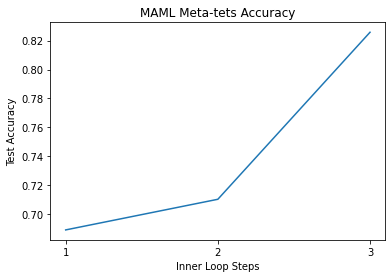

In [28]:
inner_loop_steps = [1, 2, 3]
#exectimes_hour = [2.02, 2.20, 2.53]
test_accs = [test_acc1, test_acc2, test_acc3]
print(test_accs)
plt.plot(inner_loop_steps, test_accs)
#plt.plot(inner_loop_steps, exectimes_hour)
plt.xlabel("Inner Loop Steps")
plt.xticks(inner_loop_steps, inner_loop_steps)
plt.ylabel("Test Accuracy")
_ = plt.title("MAML Meta-tets Accuracy")

## Without Feature Extractor

### Train (10 points)

Now also add feature extractor network to your meta-network and repeat the same procedure like above cells just for inner loop update = 1.


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#################################################################################
#                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
#################################################################################
# Define your config and initialize model and parameters
# prepare your data as input to your model.
# train meta-network
# get acurracy of model in meta-test phase
#################################################################################



epochs = 3
criterion = F.cross_entropy
inner_loop_steps=1
meta_inner_lr = 0.4
meta_outer_lr = 0.001



cfg = [
    *get_layer(in_channels=1, requires_grad=True, pretrained=True, feature_extractor=feature_extractor, layer_idx=0),
    *get_layer(in_channels=64, requires_grad=True, pretrained=True, feature_extractor=feature_extractor, layer_idx=1),
    *get_layer(in_channels=64, requires_grad=True, pretrained=True, feature_extractor=feature_extractor, layer_idx=2),
    *get_layer(in_channels=64, requires_grad=True, pretrained=False),
    {'layer':'flatten'},
    {'layer':'linear', 'dim':[N, 64], 'pretrained_params':None, 'requires_grad':True}
]

test_acc = train(None, cfg, epochs, train_dataloader, test_dataloader, meta_inner_lr, inner_loop_steps, meta_outer_lr, criterion)




#################################################################################
#                                   THE END                                     #
#################################################################################


100%|██████████| 1000/1000 [32:17<00:00,  1.94s/it]


train loss: 2.257792637050152.     train acc: 0.5045220929980277


100%|██████████| 1000/1000 [32:08<00:00,  1.93s/it]


train loss: 0.7130178537368774.     train acc: 0.7318445996046067


100%|██████████| 1000/1000 [32:04<00:00,  1.92s/it]


train loss: 0.49481831380724906.     train acc: 0.8198312706947327


100%|██████████| 1000/1000 [27:44<00:00,  1.66s/it]


test loss: 0.7104940785765648.     test acc: 0.7330891833305359


### Report (2.5 points)

Report accuracy of meta-test phase.

In [16]:
test_acc

0.7330891833305359

## Compare and explain Results

Answer:

<br>



همانطور که دیده شد با افزایش تعداد مراحل لوپ داخلی دقت مدل افزایش یافت (می توان حدس زد افزایش غیر خطی نیز باشد). از لحاظ شهودی نیز باید اینگونه باشد زیرا هدف در MAML یافتن نقطه اولیه ای است که بعد از اداپت شدن به تسک جدید با دیتای ترین آن تسک روی دیتای تست ان عملکرد خوبی داشته باشد. حال اگر این فرآیند اداپتیشن یک مرحله باشد نقطه شروع اولیه باید با نقطه مناسب همه تسک های متا-تست فقط یک قدم فاصله داشته باشد که بسته به ماهیت تسک ها ممکن است نتوان نقطه خوبی با این مشخصات یافت. اما اگر مراحل داخلی افزایش یابد یافتن یک نقطه اولیه مناسب می تواند روی تسک های با ماهیت متفاوت ریلکس تر باشد زیرا میتوان چند قدم بهینه سازی داخلی انجام داد. اما از طرف دیگر افزایش مراحل بهینه سازی اداپتیشن هم زمان متا-یادگیری را و هم امکانات محاسباتی را (اینجا هم احتمالا غیر خطی) افزایش می دهد. زیرا باید تعداد مراحل داخلی رو همه تسک ها افزایش یافته و از طرفی برای محاسبه گرادیان متا-پارامتر ها بعد از اداپتیشن باید تمام مسیر بهینه سازی داخلی را نگه داشت و متا-گرادیان را از آن عبور داد.

همچنین انتظار میرفت متا-آموزش کل شبکه واضحا به نتایج بهتری دست یابد زیرا در حالت متا-یادگیری کل شبکه شبکه آموزش دیده شده backbone نیز متا-آموزش داده شده و finetune می شود تا فیچر های مناسب تری را برای توزیع تسک های مساله حال حاضر ارائه دهد.